In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X, y = cancer.data, 1 - cancer.target

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
X_train.shape

(455, 30)

In [20]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(5,), activation="tanh", 
                      alpha=10, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)

from sklearn.metrics import f1_score
print(f"训练F1: { f1_score(y_train, pred_train) :.3f}")
print(f"测试F1: { f1_score(y_test, pred_test) :.3f}")

训练F1: 0.970
测试F1: 0.963


In [21]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

param_grid = {
    'hidden_layer_sizes': [(5,), (5, 2)], 
    'alpha': [10, 0.1, 0.01, 0.001] 
}


kfold = StratifiedKFold(n_splits=8, shuffle=True, random_state=1)

grid = GridSearchCV(
    MLPClassifier(activation="tanh", max_iter=1000), 
    param_grid, scoring='f1', 
    cv=kfold,
    n_jobs=-1,
    return_train_score=True,
)

grid.fit(X_train, y_train)

,estimator,MLPClassifier...max_iter=1000)
,param_grid,"{'alpha': [10, 0.1, ...], 'hidden_layer_sizes': [(5,), (5, ...)]}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,hidden_layer_sizes,"(5, ...)"


In [22]:
for model_param, test_mean, test_std, train_mean, train_std in zip(
        grid.cv_results_['params'],
        grid.cv_results_['mean_test_score'], 
        grid.cv_results_['std_test_score'],
        grid.cv_results_['mean_train_score'],
        grid.cv_results_['std_train_score'],
    ):
    print(f"test: {test_mean:0.3f}±{test_std:0.3f}, "
          f"train: {train_mean:0.3f}±{train_std:0.3f} "
          f": {model_param["hidden_layer_sizes"]},"
          f"\talpha={model_param["alpha"]}")


test: 0.973±0.019, train: 0.980±0.003 : (5,),	alpha=10
test: 0.976±0.021, train: 0.983±0.002 : (5, 2),	alpha=10
test: 0.973±0.023, train: 0.987±0.003 : (5,),	alpha=0.1
test: 0.967±0.021, train: 0.991±0.002 : (5, 2),	alpha=0.1
test: 0.979±0.023, train: 0.986±0.004 : (5,),	alpha=0.01
test: 0.979±0.015, train: 0.992±0.002 : (5, 2),	alpha=0.01
test: 0.967±0.029, train: 0.989±0.003 : (5,),	alpha=0.001
test: 0.976±0.017, train: 0.992±0.002 : (5, 2),	alpha=0.001


In [42]:
model = MLPClassifier(hidden_layer_sizes=(5, 2), activation="tanh", 
                      alpha=0.01, max_iter=1000)
model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_test  = model.predict(X_test)

from sklearn.metrics import f1_score
print(f"训练F1: { f1_score(y_train, pred_train) :.3f}")
print(f"测试F1: { f1_score(y_test, pred_test) :.3f}")

训练F1: 0.991
测试F1: 0.929


In [48]:
from sklearn.model_selection import cross_validate

model = MLPClassifier(hidden_layer_sizes=(5, 2), activation="tanh", 
                      alpha=0.01, max_iter=1000)
                      

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=2)
results = cross_validate(model, X, y, cv=kfold, scoring="f1", return_train_score=True)

train_mean = results["train_score"].mean()
train_std  = results["train_score"].std(ddof=1)
test_mean = results["test_score"].mean()
test_std  = results["test_score"].std(ddof=1)

print(f"训练: {train_mean:0.3f}±{train_std:0.3f} "
      f"测试: {test_mean:0.3f}±{test_std:0.3f}, ")

训练: 0.544±0.464 测试: 0.529±0.458, 


In [10]:
results["train_score"]

array([0.        , 0.0104712 , 0.        , 0.88297872, 0.95336788,
       0.92520776, 0.        , 0.02072539, 0.92388451, 0.02072539])

In [11]:
results["test_score"]


array([0.        , 0.        , 0.        , 0.78947368, 0.80952381,
       0.97560976, 0.        , 0.        , 0.88888889, 0.        ])

In [63]:
from sklearn.pipeline import Pipeline

mlp = MLPClassifier(hidden_layer_sizes=(5, 2), 
                    alpha=0.01, 
                    activation="tanh",
                    max_iter=1000,
                    random_state=0)

model = Pipeline([
    ('scaler', StandardScaler()), 
    ('mlp', mlp),
])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

cv = cross_validate(model, X, y, cv=kfold, 
                    scoring="f1", return_train_score=True)

train_mean = cv["train_score"].mean()
train_std  = cv["train_score"].std(ddof=1)
test_mean = cv["test_score"].mean()
test_std  = cv["test_score"].std(ddof=1)

print(f"训练: {train_mean:0.3f}±{train_std:0.3f} "
      f"测试: {test_mean:0.3f}±{test_std:0.3f}, ")
                      

训练: 0.992±0.003 测试: 0.953±0.032, 


In [53]:
cv["train_score"]

array([0.98412698, 0.9762533 , 0.97883598, 0.98153034, 0.99208443,
       0.98153034, 0.98153034, 0.97883598, 0.98153034, 0.98153034])

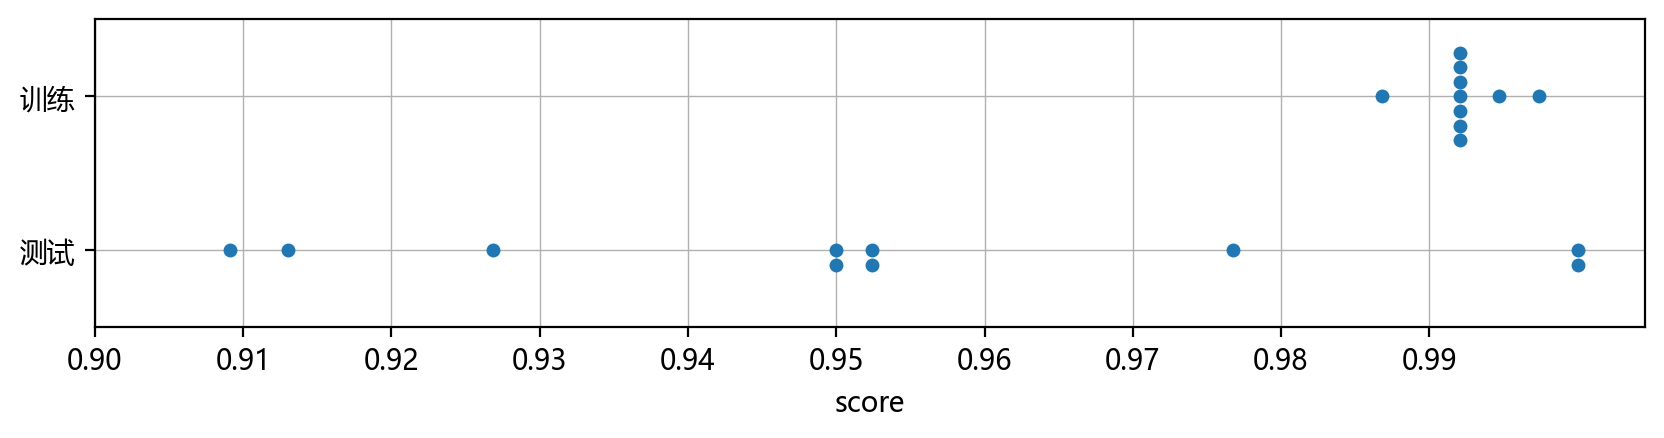

In [62]:
dft = (
    pd.DataFrame({"训练":cv["train_score"], "测试": cv["test_score"]})
    .melt(var_name="group", value_name="score")
)

fig, ax = plt.subplots(figsize=(10, 2), dpi=200)
sns.swarmplot(y='group', x='score', data=dft, dodge=True, ax=ax)
ax.set_xticks(np.arange(np.floor(dft.score.min() * 100)/100, 1, 0.01)) 
ax.grid(True, lw=0.5)
ax.set_ylabel(""); 